In [1]:
import glob
import numpy as np
import ast
import pandas as pd

from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter1d
import dynamic_extrusion_boundaries.util_visual as utvis
import seaborn as sns
import matplotlib.ticker as tkr
from polychrom.polymer_analyses import slope_contact_scaling

### conversion parameters

In [2]:
TIME_CONV_COEF = convertor= 21.875*60/500 #to convert from lattice based to seconds
LATTICE_CONV_COEF = 0.25 #each lattice site is 0.25 kb

In [3]:
file = pd.read_csv('../output/scores/simulation/scores/loop_size_converged_pair.csv')

In [4]:
lifetime = file['life']
velocity = file['vel']
clife = file['clife']
cof = file['cof']

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)

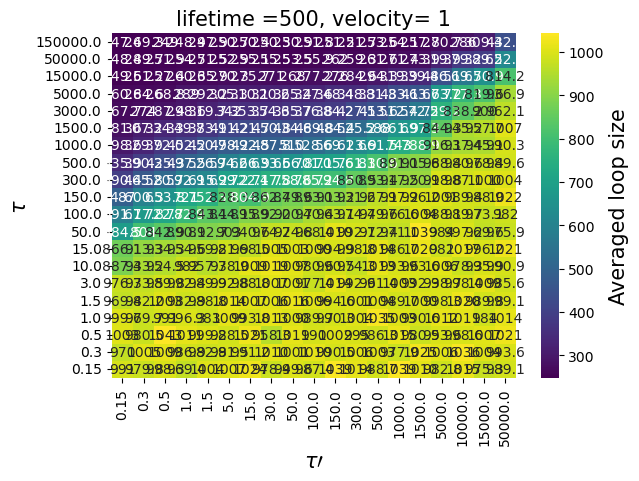

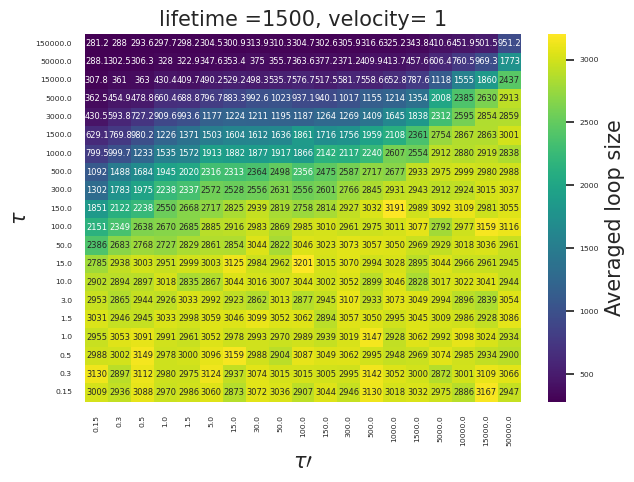

In [5]:
unique_vel = [1]
unique_life = [ 500, 1500]

for life in list(unique_life):
    for vel in list(unique_vel):
        
        new_file = file.query('life ==@life and vel==@vel')[['clife', 'cof', 'loopmean']]
        heatmap_data = new_file.pivot('clife', 'cof', 'loopmean')
        
        # Create the heatmap using seaborn
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis',  fmt='.4g', cbar_kws={'label': ' Average of loop size'})
        sns.set(font_scale=0.5)

        # Access the color bar object
        cbar = im.collections[0].colorbar
        
        # Set the font size of color bar label
        cbar.set_label('Averaged loop size', fontsize=15)  # Adjust the font size as needed
        
        # Customize labels and title
        plt.xlabel(r'$\tau\prime$', fontsize=15)
        plt.ylabel(r'$\tau$', fontsize=15)
        plt.title('lifetime =%s, velocity= %s' % (life, vel),fontsize =15)
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        #plt.savefig('averaged_loop_size_life_%s_vel_%s_sep_%s.png'%(life,vel,sep))
        plt.show()

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6


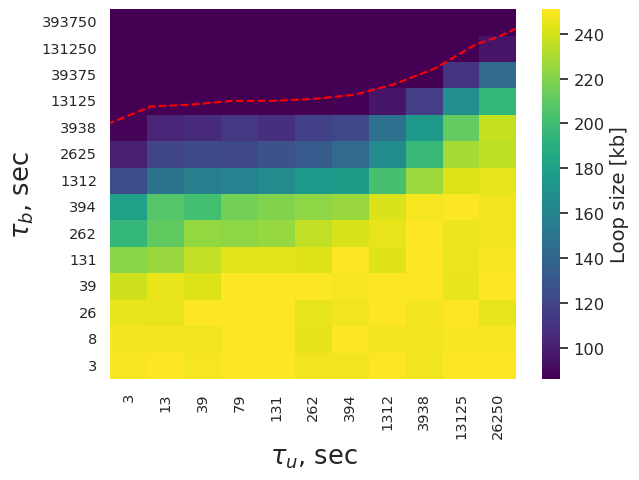

In [6]:
# Define unique values for lifetime and velocity
unique_life = [500]
unique_vel = [1]

tau_range = [1,  3,5, 10, 15, 30, 50, 100, 150, 500, 1000, 1500,5000, 15000, 50000, 150000]
taup_range = [ 1.0,  3,5.0, 10.0, 15,30,  50, 100, 150,500, 1500, 5000, 10000]

for life in unique_life:
    for vel in unique_vel:
        # Filter the data based on lifetime and velocity
        new_file = file.query(
            'life == @life and vel == @vel and clife in @tau_range and cof in @taup_range'
        )[['clife', 'cof', 'loopmean']]
        
        # Convert and round the filtered data
        new_file['clife'] = (new_file['clife'] * TIME_CONV_COEF).round().astype(int)
        new_file['cof'] = (new_file['cof'] * TIME_CONV_COEF).round().astype(int)
        new_file['loopmean'] = new_file['loopmean'] * LATTICE_CONV_COEF
        
        # Pivot the filtered data to create the heatmap data
        heatmap_data = new_file.pivot('clife', 'cof', 'loopmean')

        fig, ax = plt.subplots()

        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        ax = sns.heatmap(heatmap_data, annot=False, vmin = 86, vmax= 251,cmap='viridis', fmt='.4g', cbar_kws={'label': 'Loop size'})
        sns.set(font_scale=0.53)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        # Set the font size of color bar label
        cbar.set_label('Loop size [kb]', fontsize=14.15)

        # Add equipotential lines for loop size = 700
        number_tau = 11
        number_taup =14
        d = gaussian_filter(heatmap_data.to_numpy(), sigma=1)
        smooth_scale = 1
        cntr = ax.contour(np.linspace(0, number_tau, number_tau*smooth_scale),
                           np.linspace(0, number_taup, number_taup*smooth_scale),
                           heatmap_data.to_numpy(), levels=[350*0.25], colors='red', linestyles='dashed') 
        
        # Customize labels and title
        plt.xlabel(r'$\tau_u$, sec', fontsize=18.5)
        plt.ylabel(r'$\tau_b$, sec', fontsize=18.5)
        plt.xticks(fontsize=10.51, rotation=90)
        plt.yticks(fontsize=10.51)

        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('../output/figures/loopsize_for_pair.pdf',ppt= 500,transparent=True)
        plt.show()


In [7]:
file_stat = pd.read_csv('../output/scores/simulation/scores/merged_data_loopsize_static.csv')

In [16]:
num_plot = 5
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

In [9]:
def loop_size(t, v, delta, tau,  taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2 + (tau / ((tau + taup)*tau)) * v * ((t - (delta/2 / v))**2)
        if t > (tau+(delta/2)/(v)):
            loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2+(tau / (tau + taup)) * v * (t - (delta/2 / v) - tau/2) * 2
        return loop

def loop_size_static(t, v, delta, occupancy):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (1-occupancy) * v * (t - (delta/2 / v)) * 2
        return loop



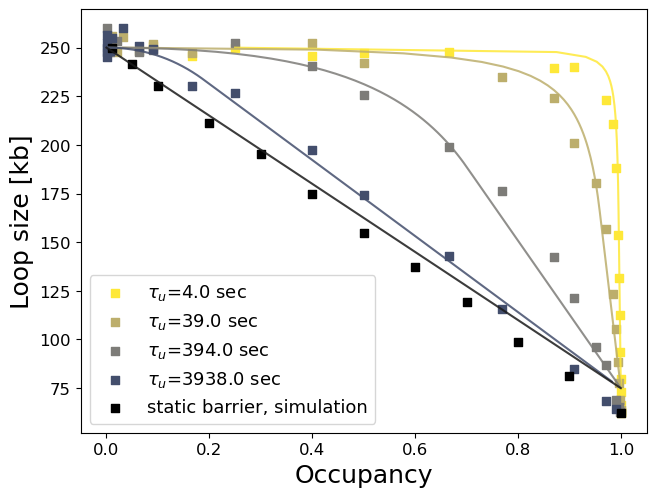

In [17]:
lifes, vels = [500] , [1]

i=1
file = pd.read_csv('../output/scores/simulation/scores/loop_size_converged_pair.csv') #importing simulated data for dynamic barriers
sns.reset_defaults()
plt.figure(figsize = (7.3,5.5))
cof_val = 10
list_cof = [1.5,15, 150, 1500]
y = [1000, 280]
for cof_val in list_cof:
    for life in lifes:
        for vel in vels:
            v=1
            new_file = file.query('life==@life and vel==@vel and cof==@cof_val')[['clife','cof', 'loopmean','loopstd']]
            new_file_filtered=new_file
            new_file_filtered = new_file_filtered.sort_values('clife')
            new_clife = new_file_filtered['clife']
            frip_score = new_file_filtered['loopmean']*LATTICE_CONV_COEF
            std = new_file_filtered['loopstd']
            plt.scatter(new_clife/(new_clife+cof_val), frip_score,  label = r'$\tau_u$=%s sec'%(np.round(cof_val*TIME_CONV_COEF)),
                        linewidth=1,s=31.5, marker = 's', color = colors[5-i])
            i+=1

i=1
file_stat = pd.read_csv('../output/scores/simulation/scores/merged_data_loopsize_static.csv') #static barriers
cof_val = 10
x = [0, 1]
y = [1000, 280]
for life in lifes:
    for vel in vels:
        i+=1
        new_file = file_stat.query('life==50 and vel==@vel and cof==0.15')[['face', 'loopmean']]
        new_file_filtered=new_file
        new_file_filtered = new_file_filtered.sort_values('face')
        new_face = new_file_filtered['face']
        frip_score = new_file_filtered['loopmean']*LATTICE_CONV_COEF
        plt.scatter(new_face, frip_score, label = r'static barrier, simulation',linewidth=1,s=31.5, marker = 's',color = 'black')


loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
tau_range = np.arange(0.5,85000,10)
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
for v_val in v_val_range:
    for taup_val in list_cof:
        for lifetime in lifetime_range:
            v=1
            loop_s = []
            for tau_val in tau_range:
                loop_size_new = loop_size(lifetime, v_val, delta_val, tau_val, taup_val)*0.25
                loop_s.append([tau_val/(tau_val+taup_val), loop_size_new])
            loop_s = np.array(loop_s)
            plt.plot(loop_s[:,0],loop_s[:,1],  alpha = 0.85, color= colors[5-i])
            i+=1

occupancy_range = np.arange(0,1.05,0.05)
lifetime_val = 500
loop_stat=[]
for occupancy_val in occupancy_range:
    loop_s = loop_size_static(lifetime_val,v=v_val,delta=delta_val,occupancy=occupancy_val)*0.25
    loop_stat.append([occupancy_val,loop_s])
loop_stat = np.array(loop_stat)
plt.plot(loop_stat[:,0],loop_stat[:,1],'-k',alpha = 0.85)#,label='static barrier')
plt.ylabel('Loop size [kb]', fontsize = 18)
plt.xlabel(r'Occupancy', fontsize = 18)
plt.xticks(fontsize = 11.95)
plt.yticks(fontsize =11.95)
plt.legend(fontsize=12.95)
plt.savefig('../output/figures/analytical_for_loop_size.pdf',transparent =True)
plt.show()  


### derivative analysis of theoretical loop size

In [11]:
def smooth(x, sigma = 1.75):
        return gaussian_filter1d(x, sigma)

In [12]:
num_plot = 12
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

In [13]:
def loop_size(t, v, delta, tau,  taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2 + (tau / ((tau + taup)*tau)) * v * ((t - (delta/2 / v))**2)
        if t > (tau+(delta/2)/(v)):
            loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2+(tau / (tau + taup)) * v * (t - (delta/2 / v) - tau/2) * 2
        return loop

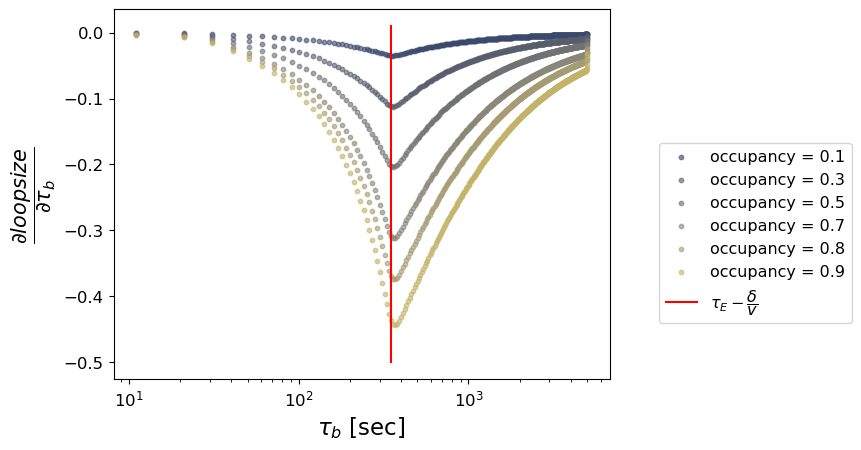

In [14]:
loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
taup_range = [1.5,15, 50, 150,500, 1500, 5000]
tau_range = np.arange(1,5000,10)
occup_range = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9]
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
sns.reset_defaults()
convertor=1
colors = viridis_cmap(np.linspace(0, 1, 10))
for v_val in v_val_range:
    for occupa in occup_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                taup_val = tau_val*(1-occupa)/occupa
                occup = np.round(tau_val/(tau_val+taup_val),3)
                loop_size_new = loop_size(lifetime, v_val, delta_val, tau_val, taup_val)
                loop_s.append([tau_val, loop_size_new])
            loop_s = np.array(loop_s)
            s, der = slope_contact_scaling(loop_s[:,0], smooth(loop_s[:,1]), sigma=1)
            plt.scatter(s*convertor,der, s =10, alpha=0.6, color=colors[i],label = 'occupancy = %s'%occup)
point = (lifetime-delta_val/(2*v_val))*convertor
plt.plot([point,point] ,[-0.5, 0.01],color='red', label = r'$\tau_E-\dfrac{\delta}{v}$')

plt.ylabel(r'$\dfrac{\partial loop size}{\partial \tau_b}$', fontsize = 15)
plt.xlabel(r'$\tau_b$ [sec]', fontsize = 16.5)
plt.xscale('log')
plt.xticks(fontsize =11.95)
plt.yticks(fontsize = 11.95)
plt.legend(loc=(1.1,0.15), fontsize = 11.5)
plt.savefig('../output/figures/loop_derivetive.pdf', transparent = True)
plt.show()  
